# Fitting an Individual Power Spectrum

In this example, we will fit an individual power spectrum model.

## Load Python libraries

First, we will load the Python modules we need for this example.

In [1]:
# Import some useful standard library modules
import os
from pathlib import Path

# Import some general scientific python libraries
import numpy as np
import pandas as pd

# Import the parameterization model object
from fooof import FOOOF

### Check specparam version

In [2]:
import fooof
print(fooof.__version__)

1.0.0


## Set data path

Next, we can set the path to where the data is available.

In [3]:
# Check working directory
os.getcwd()

'/Users/tom/Code/ModCode/param_repos/DevDemo/Code/Jupyter'

In [4]:
# Set the data path to load from
data_path = Path('../../Data/')

## Load invididual PSD

Load CSV files, including:
- `freqs.csv`, which contains a vector of frequencies
- `indvPSD.csv`, which contains the power values for an individual power spectrum

In [5]:
# Load data
freqs = np.ravel(pd.read_csv(data_path / "freqs.csv"))                                                             
spectrum = np.ravel(pd.read_csv(data_path / "indvPSD.csv"))  

In [6]:
# Check shapes of loaded data
print(freqs.shape)
print(spectrum.shape)

(50,)
(50,)


## Parameterize a power spectrum

Now we can parameterize our power spectrum!

In [7]:
# Initialize a model object for spectral parameterization, with some settings 
fm = FOOOF(peak_width_limits= [1, 8], max_n_peaks= 8, min_peak_height= 0.05, verbose=False)  

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 30 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.9150, 1.7822                                          
                                                                                                  
                                       2 peaks were found:                                        
          

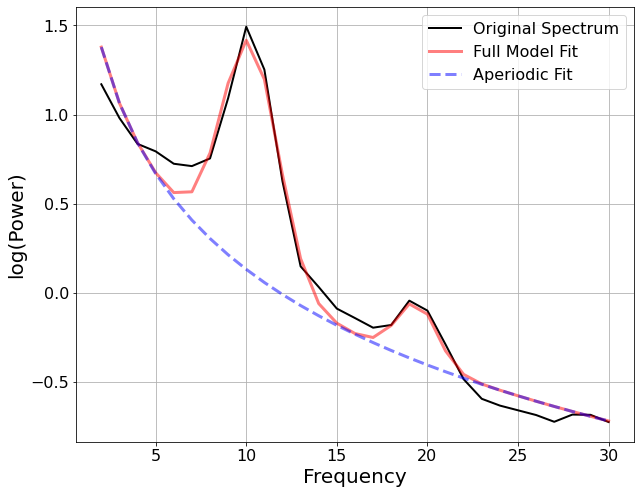

In [8]:
# Fit individual PSD over 1-30 Hz range      
fm.report(freqs, spectrum, [2, 30])

In [9]:
# Save out a copy of the model fit report
fm.save_report('INDV_demo')

# The following line can also be used to save out the model plot
#fm.plot(save_fig=True, file_name="INDV_demo")

## Access model fit information

All of the model fit information is saved to the model object. 

Note that all attributes learned in the model fit process have a trailing underscore. 

In [10]:
# Access the model fit parameters from the model object
print('Aperiodic parameters: \n', fm.aperiodic_params_, '\n')
print('Peak parameters: \n', fm.peak_params_, '\n')
print('Goodness of fit:')
print('Error - ', fm.error_)
print('R^2   - ', fm.r_squared_, '\n')
print('Number of fit peaks: \n', fm.n_peaks_)

Aperiodic parameters: 
 [1.91498762 1.78217891] 

Peak parameters: 
 [[10.20629741  1.284451    3.12864068]
 [19.42705933  0.30269383  2.19509516]] 

Goodness of fit:
Error -  0.06605727179840666
R^2   -  0.9863407949050128 

Number of fit peaks: 
 2


## Extract periodic and aperiodic parameters

Another way to access model fit parameters is to use the `get_params` method, which can be used to access model fit attributes. 

In [11]:
# Extract aperiodic and full periodic parameter
aps = fm.get_params('aperiodic_params')
peaks = fm.get_params('peak_params')

In [12]:
# Extract goodness of fit information 
error = fm.get_params('error')
r2 = fm.get_params('r_squared')

In [13]:
# Extract specific parameters
exp = fm.get_params('aperiodic_params', 'exponent')   
cfs = fm.get_params('peak_params', 'CF')

## Save files

The model object also has I/O utilities for saving and reloading data. 

The `save` method can be used to save out data from the object, specifying which information to save. 

In [14]:
# Save out the settings used to fit the model
fm.save('fit_settings', save_settings=True)

In [15]:
# Save out the results of the model fit
fm.save('fit_results', save_results=True)

In [16]:
# Save out a copy of the data used to fit the model
fm.save('fit_data', save_data=True)

## Reload 

We can also check our saved out results by reloading them. 

In [17]:
# Reload the saved out model result
nfm = FOOOF()
nfm.load('fit_results')

In [18]:
# Check the results of the reloaded model fit
nfm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 30 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.9150, 1.7822                                          
                                                                                                  
                                       2 peaks were found:                                        
          